<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#(Run-model-until-August-1)" data-toc-modified-id="(Run-model-until-August-1)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>(Run model until August 1)</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li></ul></li><li><span><a href="#Scenarios" data-toc-modified-id="Scenarios-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scenarios</a></span><ul class="toc-item"><li><span><a href="#S1-(worst-case):-continuation-of-september-contact-behaviour" data-toc-modified-id="S1-(worst-case):-continuation-of-september-contact-behaviour-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>S1 (worst-case): continuation of september contact behaviour</a></span></li><li><span><a href="#S2:-Contacts-reduced-only-half-as-much-as-in-previous-lockdown" data-toc-modified-id="S2:-Contacts-reduced-only-half-as-much-as-in-previous-lockdown-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>S2: Contacts reduced only half as much as in previous lockdown</a></span></li><li><span><a href="#S3:-Contacts-reduced-as-much-as-in-previous-lockdown" data-toc-modified-id="S3:-Contacts-reduced-as-much-as-in-previous-lockdown-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>S3: Contacts reduced as much as in previous lockdown</a></span></li><li><span><a href="#Other-scenarios" data-toc-modified-id="Other-scenarios-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Other scenarios</a></span><ul class="toc-item"><li><span><a href="#Decrease-contacts-50%-(except-schools)" data-toc-modified-id="Decrease-contacts-50%-(except-schools)-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Decrease contacts 50% (except schools)</a></span></li><li><span><a href="#Decrease-contacts-25%-(except-schools)" data-toc-modified-id="Decrease-contacts-25%-(except-schools)-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Decrease contacts 25% (except schools)</a></span></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Make-a-dataframe-to-output" data-toc-modified-id="Make-a-dataframe-to-output-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make a dataframe to output</a></span></li></ul></div>


*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [21]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data, policy and model initialization

## Load contact data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
# Define the number of age categories
levels = initN.size
#province_names = pd.read_csv('../data/raw/GIS/NIS_province.csv')
initN_province = pd.read_csv('../data/interim/demographic/initN_province.csv')
initN = np.array(list(initN_province.set_index('NIS').loc[60000].iloc[:9]))

## Load publically available data from Sciensano

In [3]:
#df_sciensano = sciensano.get_sciensano_COVID19_data(update=True)
raw_hosp_data = pd.read_csv('../data/raw/sciensano/COVID19BE_HOSP.csv', parse_dates=['DATE'])
Luik_hosp_data = raw_hosp_data[raw_hosp_data.PROVINCE=='Liège']
# TOTAL_IN = H_tot !

## (Run model until August 1)

In [ ]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [ ]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 500,
              'l': 1,
              'tau': 5,
              'prevention': 0.5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

In [ ]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave1_1000steps_2020-10-28.json', 'r') as fp:
    samples_dict_wave1 = json.load(fp)

In [ ]:
# Update this parameter here, the rest is updated by draw_sample_COVID19_SEIRD
model.parameters['policy_time'] = samples_dict_wave1['lag_time']

In [ ]:
# out_aug = model.sim(time='2020-08-01', excess_time=samples_dict_wave1['lag_time'],start_date='2020-03-15',
#                    N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
# states = out_aug.isel(time=-1).mean(dim="draws")
# initial_states_aug = {key:states[key].values for key in initial_states.keys()}

In [ ]:
## To work with Tijs' lockdown function, use int here:
t = (pd.to_datetime('2020-08-01') - pd.to_datetime('2020-03-15'))/pd.to_timedelta('1D')
out_aug = model.sim(time=139,start_date='2020-03-15',
                   N=100, draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict_wave1)
states = out_aug.isel(time=-1).mean(dim="draws")
initial_states_aug = {key:states[key].values for key in initial_states.keys()}

## Load posterior parameter distributions of calibrated parameters

In [4]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../data/interim/model_parameters/provinces/Luik_wave2_from_aug_1000steps_2020-10-29.json', 'r') as fp:
    samples_dict_wave2 = json.load(fp)

# Scenarios

In [6]:
start_date = '2020-08-01'
n_draws = 100
percentile = 0.95
end_date = '2021-01-01'
dates_full = pd.date_range(start_date, end_date)

In [68]:
initial_states_aug = np.load('../data/interim/prediction_provinces/Luik_initial_states_aug.npy', allow_pickle=True).item()

## S1 (worst-case): continuation of september contact behaviour

In [7]:
def draw_sample_beta_COVID19_SEIRD(parameter_dictionary,samples_dict):
    """
    A function to draw parameter samples obtained with MCMC during model calibration and assign them to the parameter dictionary of the model.
    Tailor-made for the BIOMATH COVID-19 SEIRD model.

    Parameters
    ----------
    model : object
        BIOMATH model object
    
    samples_dict : dictionary
        Dictionary containing the samples of the sampled parameters: beta, l and tau.

    Returns
    ----------
    model : object
        BIOMATH model object

    """
    # Use posterior samples of fitted parameters
    parameter_dictionary['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    return parameter_dictionary

In [9]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params)
# Run simulation
out_S1 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_wave2)
# Save results
# New hospitalisations
S1_incidences_mean = out_S1["H_in"].sum(dim="Nc").mean(dim="draws").values
S1_incidences_median = out_S1["H_in"].sum(dim="Nc").median(dim="draws").values
S1_incidences_LL = out_S1["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S1_incidences_UL = out_S1["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S1_load_mean = out_S1["H_tot"].sum(dim="Nc").mean(dim="draws").values
S1_load_median = out_S1["H_tot"].sum(dim="Nc").median(dim="draws").values
S1_load_LL = out_S1["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S1_load_UL = out_S1["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


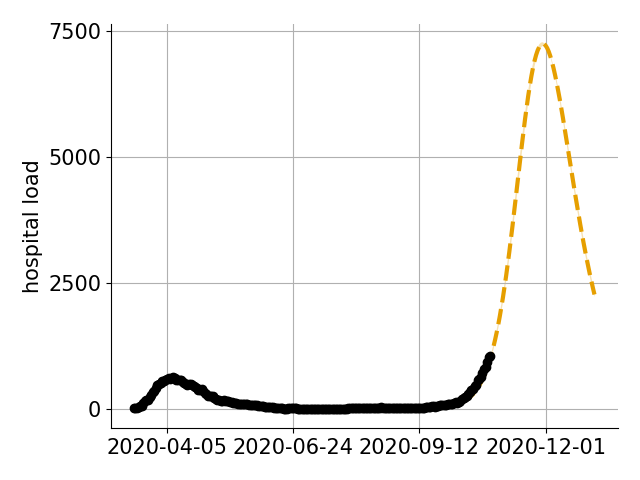

In [10]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S1["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S1["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()


In [ ]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S1["H_in"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S1["H_in"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S1["H_in"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["NEW_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('daily hospitalisations')
fig.tight_layout()


## S2: Contacts reduced only half as much as in previous lockdown

In [47]:
def contact_reduction_half(t, param, policy0, policy_half, policy_half_school_vacation):
    if t < pd.to_datetime('2020-10-19'):
        return policy0
    elif t >= pd.to_datetime('2020-10-19'):
        return policy_half
    elif t >= pd.to_datetime('2020-11-02'):
        return policy_half_school_vacation
    elif t > pd.to_datetime('2020-11-11'):
        return policy_half
    elif t >= pd.to_datetime('2020-12-21'):
        return policy_half_school_vacation

In [48]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({      'policy0': Nc_total,
                 'policy_half': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + 1*Nc_schools + (1-0.40)*Nc_leisure,
 'policy_half_school_vacation': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.35)*Nc_transport + (1-0.15)*Nc_others + 0*Nc_schools + (1-0.40)*Nc_leisure,
})

# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_half})
# Run simulation
out_S2 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_wave2)
# Save results
# New hospitalisations
S2_incidences_mean = out_S2["H_in"].sum(dim="Nc").mean(dim="draws").values
S2_incidences_median = out_S2["H_in"].sum(dim="Nc").median(dim="draws").values
S2_incidences_LL = out_S2["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_incidences_UL = out_S2["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S2_load_mean = out_S2["H_tot"].sum(dim="Nc").mean(dim="draws").values
S2_load_median = out_S2["H_tot"].sum(dim="Nc").median(dim="draws").values
S2_load_LL = out_S2["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_load_UL = out_S2["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


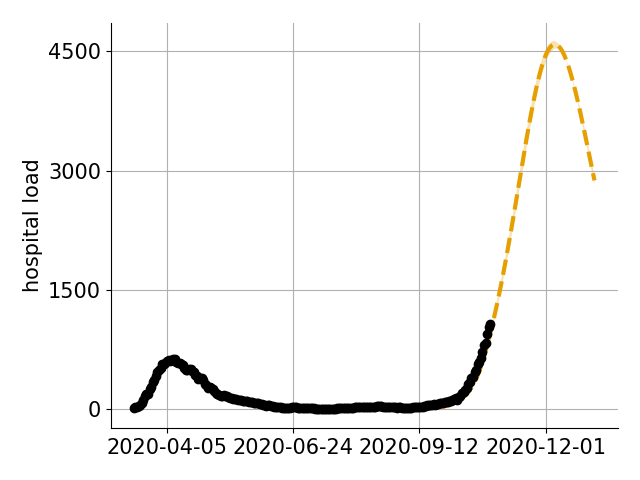

In [49]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S2["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S2["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S2["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()

## S3: Contacts reduced as much as in previous lockdown

In [51]:
def contact_reduction_full(t, param, policy0, policy_full, policy_full_school_vacation):
    if t < pd.to_datetime('2020-10-19'):
        return policy0
    elif t >= pd.to_datetime('2020-10-19'):
        return policy_full
    elif t >= pd.to_datetime('2020-11-02'):
        return policy_full_school_vacation
    elif t > pd.to_datetime('2020-11-11'):
        return policy_full
    elif t >= pd.to_datetime('2020-12-21'):
        return policy_full_school_vacation

In [52]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({     'policy0': Nc_total,
                'policy_full': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + 1*Nc_schools + (1-0.80)*Nc_leisure,
'policy_full_school_vacation': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + 0*Nc_schools + (1-0.80)*Nc_leisure,
})
# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_full})
# Run simulation
out_S3 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_wave2)
# Save results
# New hospitalisations
S3_incidences_mean = out_S3["H_in"].sum(dim="Nc").mean(dim="draws").values
S3_incidences_median = out_S3["H_in"].sum(dim="Nc").median(dim="draws").values
S3_incidences_LL = out_S3["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S3_incidences_UL = out_S3["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S3_load_mean = out_S3["H_tot"].sum(dim="Nc").mean(dim="draws").values
S3_load_median = out_S3["H_tot"].sum(dim="Nc").median(dim="draws").values
S3_load_LL = out_S3["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S3_load_UL = out_S3["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


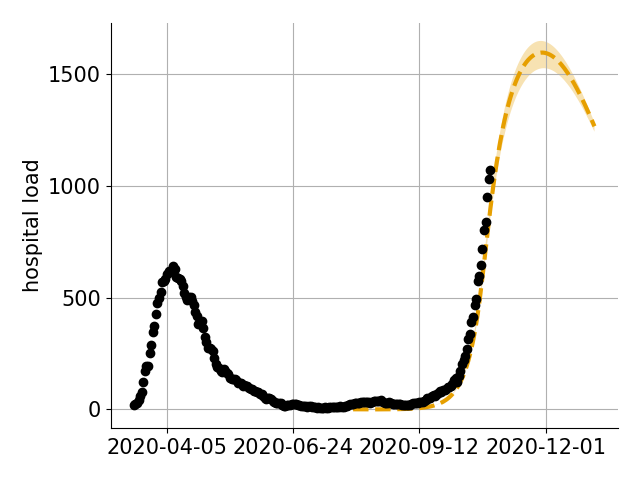

In [53]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S3["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S3["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S3["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()

## Other scenarios

### Decrease contacts 50% (except schools)

In [16]:
def contact_reduction_50(t, param, policy0, policy_50p):
    if t < pd.to_datetime('2020-10-19'):
        return policy0
    elif t >= pd.to_datetime('2020-10-19'):
        return policy_50p

In [28]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy0': Nc_total,
              'policy_50p': 1.0*Nc_home + 0.5*Nc_work + 0.5*Nc_transport + 0.5*Nc_others + 0.5*Nc_leisure + Nc_schools})

# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_50})
# Run simulation
out_S2 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_wave2)
# Save results
# New hospitalisations
S2_incidences_mean = out_S2["H_in"].sum(dim="Nc").mean(dim="draws").values
S2_incidences_median = out_S2["H_in"].sum(dim="Nc").median(dim="draws").values
S2_incidences_LL = out_S2["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_incidences_UL = out_S2["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S2_load_mean = out_S2["H_tot"].sum(dim="Nc").mean(dim="draws").values
S2_load_median = out_S2["H_tot"].sum(dim="Nc").median(dim="draws").values
S2_load_LL = out_S2["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S2_load_UL = out_S2["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


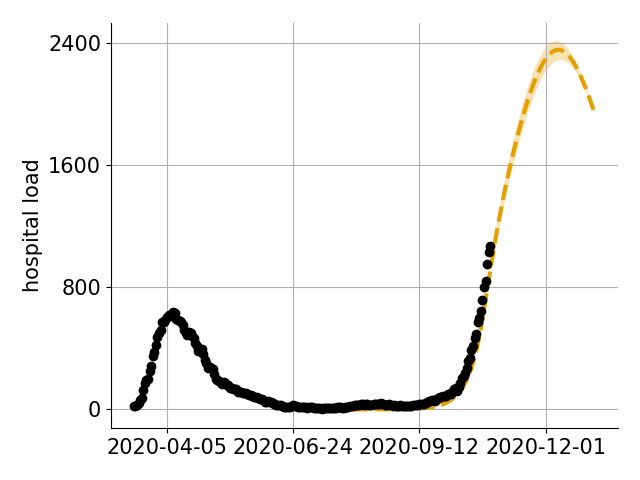

In [26]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S2["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S2["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S2["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()

### Decrease contacts 25% (except schools)

In [27]:
def contact_reduction_25(t, param, policy0, policy_25p):
    if t < pd.to_datetime('2020-10-19'):
        return policy0
    elif t >= pd.to_datetime('2020-10-19'):
        return policy_25p

In [29]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'policy0': Nc_total,
              'policy_25p': 1.0*Nc_home + 0.25*Nc_work + 0.25*Nc_transport + 0.25*Nc_others + 0.25*Nc_leisure + Nc_schools})

# Define the initial condition: one exposed inidividual in every age category
initial_states = initial_states_aug
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': contact_reduction_25})
# Run simulation
out_S3 = model.sim(time=end_date, excess_time=0, start_date=start_date,
                   N=n_draws,draw_fcn=draw_sample_beta_COVID19_SEIRD,samples=samples_dict_wave2)
# Save results
# New hospitalisations
S3_incidences_mean = out_S3["H_in"].sum(dim="Nc").mean(dim="draws").values
S3_incidences_median = out_S3["H_in"].sum(dim="Nc").median(dim="draws").values
S3_incidences_LL = out_S3["H_in"].sum(dim="Nc").quantile(0.2,dim="draws").values
S3_incidences_UL = out_S3["H_in"].sum(dim="Nc").quantile(0.8,dim="draws").values
# Hospital totals
S3_load_mean = out_S3["H_tot"].sum(dim="Nc").mean(dim="draws").values
S3_load_median = out_S3["H_tot"].sum(dim="Nc").median(dim="draws").values
S3_load_LL = out_S3["H_tot"].sum(dim="Nc").quantile(0.2,dim="draws").values
S3_load_UL = out_S3["H_tot"].sum(dim="Nc").quantile(0.8,dim="draws").values

<IPython.core.display.Javascript object>


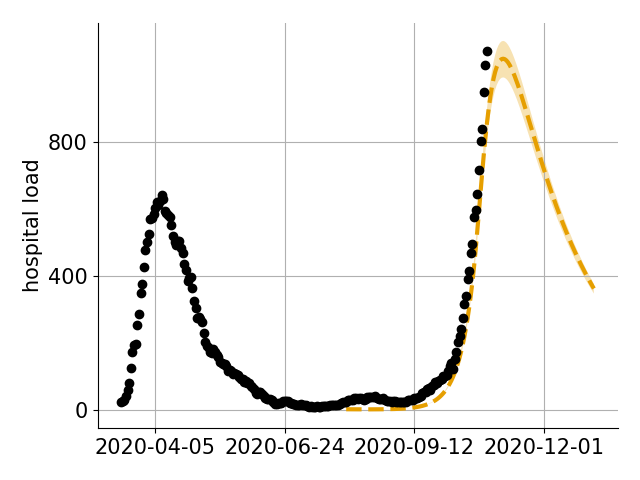

In [30]:
fig,ax =plt.subplots()
ax.fill_between(dates_full, out_S3["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), out_S3["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(dates_full,out_S3["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'o',color='black')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('hospital load')
fig.tight_layout()

# Summary

<IPython.core.display.Javascript object>


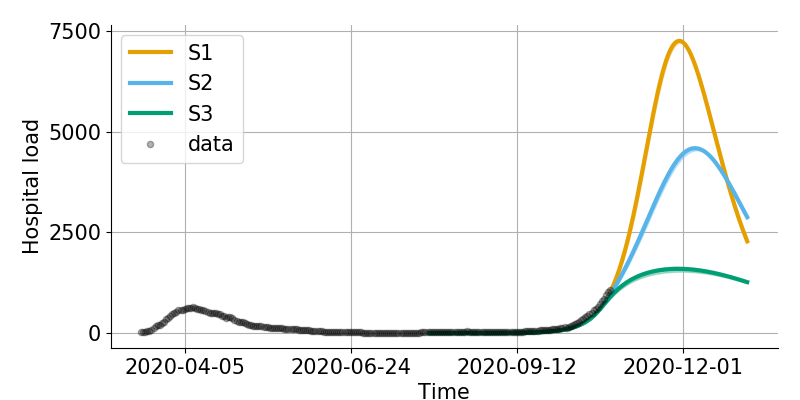

In [67]:
fig,ax =plt.subplots(figsize=(8,4))
ax.fill_between(dates_full, out_S1["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"),
                out_S1["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30, color='C0')
ax.plot(dates_full,out_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'-', color='C0', label='S1')

ax.fill_between(dates_full, out_S2["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"),
                out_S2["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30, color='C1')
ax.plot(dates_full,out_S2["H_tot"].mean(dim="draws").sum(dim="Nc"),'-', color='C1', label='S2')

ax.fill_between(dates_full, out_S3["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), 
                out_S3["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30, color='C2')
ax.plot(dates_full,out_S3["H_tot"].mean(dim="draws").sum(dim="Nc"),'-', color='C2', label='S3')

ax.plot(Luik_hosp_data.DATE,Luik_hosp_data["TOTAL_IN"],'.',color='black', markersize=9, alpha=0.3, label='data')
# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)
ax.set_ylabel('Hospital load')
fig.tight_layout()
ax.set_xlabel('Time')
plt.legend()
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.savefig('../results/predictions_provinces/Luik_combined_results.jpg', dpi=400, bbox_inches='tight')

# Make a dataframe to output

In [ ]:
start_date = datetime.datetime.strptime('15-03-2020', '%d-%m-%Y') - datetime.timedelta(days=samples_dict['lag_time'])
index = pd.date_range(start_date, periods=simtime+1).date

In [ ]:
columns = ['S1_incidences_mean','S1_incidences_median','S1_incidences_LL','S1_incidences_UL','S1_load_mean','S1_load_LL','S1_load_UL','S2_incidences_mean','S2_incidences_median','S2_incidences_LL','S2_incidences_UL','S2_load_mean','S2_load_LL','S2_load_UL','S3_incidences_mean','S3_incidences_median','S3_incidences_LL','S3_incidences_UL','S3_load_mean','S3_load_LL','S3_load_UL','S4_incidences_mean','S4_incidences_median','S4_incidences_LL','S4_incidences_UL','S4_load_mean','S4_load_LL','S4_load_UL']

In [ ]:
data = np.transpose(np.array([S1_incidences_mean,S1_incidences_median,S1_incidences_LL,S1_incidences_UL,S1_load_mean,S1_load_LL,S1_load_UL,S2_incidences_mean,S2_incidences_median,S2_incidences_LL,S2_incidences_UL,S2_load_mean,S2_load_LL,S2_load_UL,S3_incidences_mean,S3_incidences_median,S3_incidences_LL,S3_incidences_UL,S3_load_mean,S3_load_LL,S3_load_UL,S4_incidences_mean,S4_incidences_median,S4_incidences_LL,S4_incidences_UL,S4_load_mean,S4_load_LL,S4_load_UL]))

In [ ]:
df = pd.DataFrame(data,columns=columns,index=index)
df.head()

In [ ]:
df.to_csv('../results/FAGG-long-term-predictions/'+datetime.datetime.today().strftime('%Y-%m-%d')+'recalibration.csv',index=True)